In [66]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_datareader as pdr
from statsmodels import api as sm
from re import match
from datetime import datetime as dt
from sqlalchemy import create_engine
import mplfinance as mplf

sns.set()
sns.set(rc={'figure.figsize':(30,8)})
SNS_CMAP = sns.light_palette("seagreen", as_cmap=True)
SNS_COLOR = sns.color_palette('muted')

## Minute DB

In [556]:
symbols = ['EURUSD']#,'USDJPY','GBPUSD','USDCHF','AUDUSD','USDCAD','NZDUSD']

db_url = 'sqlite:///data/minute_data/fx_min_data.db'
db_engine = create_engine(db_url, echo=False)

data = dict()
for symbol in symbols:
    query = f'''
SELECT "Datetime","Open","High","Low","Close","Volume" FROM {symbol}
WHERE Datetime >= "2000-01-01"
ORDER BY Datetime ASC
'''
    df = pd.read_sql(query,db_engine,
                    index_col='Datetime')
    df.index = pd.DatetimeIndex(df.index)
    df.sort_index(inplace=True)
    df = df[~df.index.duplicated(keep='first')] # drop duplicates
    data[symbol] = df
db_engine.dispose()

In [557]:
def resample(data,freq='1h',open='Open',high='High',low='Low',close='Close',volume='Volume'):
  o,h,l,c,v = data[open],data[high],data[low],data[close],data[volume]
  sample = pd.DataFrame()
  sample[open] = o.resample(freq).first()
  sample[high] = h.resample(freq).max()
  sample[low] = l.resample(freq).min()
  sample[close] = c.resample(freq).last()
  sample[volume] = v.resample(freq).sum()
  return sample

In [558]:
for symbol in symbols:
  data[symbol] = resample(data[symbol],freq='d').dropna()

# Yfinance

In [1079]:
symbols = ['SPY','GLD']
for symbol in symbols:
  data[symbol] = yf.download(symbol).drop(columns='Adj Close')
  data[symbol].index.name = 'Datetime'

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Strategy

In [1080]:
def EWMAC(close,window):
  fast = close.ewm(window).mean()
  slow = close.ewm(window*4).mean()
  ewmac = fast - slow
  vol = np.log(close).diff().rolling(21).std()
  signal = ewmac / (vol * close)
  signal = signal.clip(lower=-2,upper=2)
  return signal

def DCB(high,low,close,window):
  upper = high.rolling(window).max().shift(1)
  lower = low.rolling(window).min().shift(1)
  middle = (upper + lower) / 2
  signal = (close - middle) / (upper - lower) * 2
  signal = signal.clip(lower=-2,upper=2)
  return signal

def MR(close,window):
  mean = close.rolling(window).mean()
  vol = np.log(close).diff().rolling(window).std()
  z = (close - mean) / (vol * close).shift(1)
  signal = -z
  signal = signal.clip(lower=-2,upper=2)
  return signal

In [1081]:
signals = dict()

for symbol in symbols:
  o,h,l,c,v = data[symbol].Open,data[symbol].High,data[symbol].Low,data[symbol].Close,data[symbol].Volume
  signal = pd.DataFrame()

  for speed in [16,32,48,64]:
    signal[f'EWMAC_{speed}'] = EWMAC(c,speed)
    
  #for speed in [20,60,120,240]:
  #  signal[f'DCB_{speed}'] = DCB(h,l,c,speed)

  for speed in [5,10,15,20]:
   signal[f'MR_{speed}'] = MR(c,speed)
  
  signals[symbol] = signal

In [1082]:
pnls = dict()

for symbol in symbols:
  logprc = np.log(data[symbol].Close)
  vol = logprc.rolling(252).std() # scaling the profit
  
  pnl = signals[symbol].mul((logprc.diff().shift(-1)),axis=0)
  
  pnls[symbol] = pnl #- 0.00006 * signals[symbol].diff().abs()

In [1083]:
train_index = pnl.index[:round(pnl.shape[0]*0.5)]

EWMAC_16: 0.05029725072852385
EWMAC_32: 0.07916505978377825
EWMAC_48: -0.019507765123080254
EWMAC_64: -0.04624012840277697
MR_5: -0.30439565354827236
MR_10: -0.45242427588152984
MR_15: -0.49868328479665064
MR_20: -0.47470238998482905


<Axes: xlabel='Datetime'>

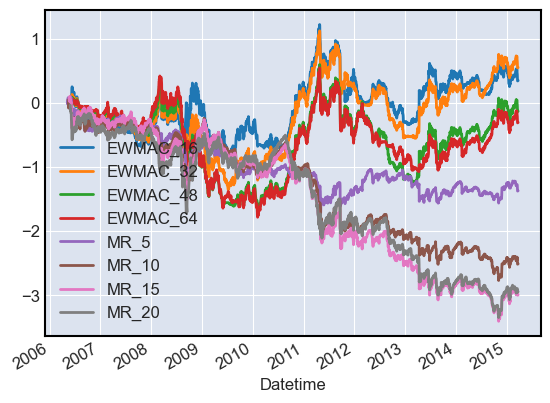

In [1084]:
for name in signal.columns:
  daily_pnl = pnl[name].loc[train_index].resample('D').sum()
  mu = daily_pnl.mean()
  sig = daily_pnl.std()
  sr = mu / sig * 252**0.5
  print(f'{name}: {sr}')
pnl.loc[train_index].cumsum().plot()

# Metalabelling

In [1085]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(np.around(dfoutput,6))

In [1086]:
features = dict()
for symbol in symbols:
  features[symbol] = pd.DataFrame(index=data[symbol].index)

## TA features

In [1087]:
from ta.momentum import RSIIndicator as RSI
from ta.momentum import StochasticOscillator as STO
from ta.volume import VolumeWeightedAveragePrice as VWAP
from ta.volatility import AverageTrueRange as ATR
from ta.trend import MACD
from ta.trend import ADXIndicator as ADX

for symbol in symbols:
  o,h,l,c,v = data[symbol].Open,data[symbol].High,data[symbol].Low,data[symbol].Close,data[symbol].Volume
  
  ta = pd.DataFrame()
  for w in [4,8,16,32,64,128,264]:
    ta[f'RSI_{w}'] = RSI(c,w).rsi()
    ta[f'STO_{w}'] = STO(c,h,l,w).stoch()
    ta[f'VLM_{w}'] = np.log(v).ffill().diff().rolling(w).mean()
    ta[f'VWAP_{w}'] = np.log(VWAP(h,l,c,v,w).volume_weighted_average_price()).diff()
    ta[f'VOL_{w}'] = np.log(c).ffill().diff().rolling(w).std()
    ta[f'ATR_{w}'] = (ATR(h,l,c,w).average_true_range())
    ta[f'MACD_{w}'] = MACD(c,
                           window_slow=w*2,
                           window_fast=w,
                           window_sign=w*0.5).macd_diff()
    ta[f'ADX_{w}'] = ADX(h,l,c,w).adx()
  ta.replace([np.inf, -np.inf], np.nan, inplace=True)
  ta.ffill(inplace=True)
  features[symbol] = features[symbol].merge(ta,on='Datetime',how='outer')

## Fundamental features

In [1088]:
from pandas_datareader.famafrench import FamaFrenchReader as FFR

fund = pd.DataFrame()
vix = yf.download(['^VIX']).Close
evz = yf.download(['^EVZ']).Close
usd = yf.download(['DX-Y.NYB']).Close
ff5 = FFR('F-F_Research_Data_5_Factors_2x3_daily',start='1990-01-01').read()[0]
fund['VIX'] = vix
#fund['EVZ'] = evz
fund['USD'] = np.log(usd).diff()
fund['MKT'] = ff5['Mkt-RF']
fund['SMB'] = ff5.SMB
fund['HML'] = ff5.HML
fund['RMW'] = ff5.RMW
fund['CMA'] = ff5.CMA
fund['RF'] = ff5.RF
fund.index.name = 'Datetime'

for symbol in symbols:
  features[symbol] = features[symbol].merge(fund,on='Datetime',how='outer')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Test

In [1089]:
def center(s):
  mean = s.rolling(252).mean()
  zero_mean_s = s - mean
  return zero_mean_s

def normalize(s):
  zero_mean_var = (s**2).rolling(252).mean()
  zero_mean_std = np.sqrt(zero_mean_var)
  norm_s = s / zero_mean_std
  return norm_s

def smooth(s):
  return s.ewm(alpha=0.05).mean()

In [1090]:
for symbol in symbols:
  features[symbol] = features[symbol].apply(center).apply(normalize)

In [1091]:
def label(s):
  win = np.where(s>0,1,0)
  lose = np.where(s<0,-1,0)
  label = pd.Series(win+lose,index=s.index)
  return label

In [1098]:
from sklearn.ensemble import RandomForestClassifier

meta_preds = dict()

for symbol in symbols:
  pnl = pnls[symbol]
  feature = features[symbol]
  signal = signals[symbol]
  logprc = np.log(data[symbol].Close)
  vol = logprc.diff().rolling(252).std()
  meta_pred = pd.DataFrame()
  
  for strat in pnl.columns:
    print(f'Fitting {symbol} {strat}')
    #w = int(strat.split('_')[1])
    pnl_label = label(pnl[strat] / vol)
    
    df = pd.concat([pnl_label,feature],axis=1).ffill().dropna()
    rf = RandomForestClassifier(n_estimators=1000,max_depth=3)

    train_index = df.index[:round(df.shape[0]*0.5)]
    test_index = df.index[round(df.shape[0]*0.5)+252:]

    rf.fit(y=df.iloc[:,0].loc[train_index],
           X=df.iloc[:,1:].loc[train_index])
    
    pred = pd.Series(rf.predict(X=df.iloc[:,1:]),index=df.index)
    meta_pred[strat] = pred
  
  meta_preds[symbol] = meta_pred
    #valid = pd.DataFrame()
    #valid['true'] = df.iloc[:,0].loc[train_index]
    #valid['pred'] = rf.predict(X=df.iloc[:,1:].loc[train_index])
    #valid['tp'] = np.where(valid.true == valid.pred,1,0)
    #print(valid['tp'].mean())

Fitting SPY EWMAC_16


KeyboardInterrupt: 

In [1093]:
meta_pnls = dict()

for symbol in symbols:
  pnl = pnls[symbol]
  meta_pred = meta_preds[symbol]
  signal = signals[symbol]
  logprc = np.log(data[symbol].Close)
  
  meta_signal = signal * meta_pred.clip(lower=0)
  #for strat in signal.columns:
  #  w = int(strat.split('_')[1])
  #  meta_signal[strat] = meta_signal[strat].rolling(w).mean()
    
  meta_pnl = meta_signal.mul(logprc.diff().shift(-1),axis=0) - 0.00006 * meta_signal.diff().abs()
  meta_pnls[symbol] = meta_pnl

In [1094]:
sr_df = pd.DataFrame()

for symbol in symbols:
  meta_pnl = meta_pnls[symbol]
  pnl = pnls[symbol]
  for strat in pnl.columns:
    daily_meta_pnl = meta_pnl.loc[test_index,strat]
    daily_pnl = pnl.loc[test_index,strat]
    
    meta_mu = daily_meta_pnl.mean()
    meta_sig = daily_meta_pnl.std()
    meta_sr = meta_mu / meta_sig * 252**0.5
    
    mu = daily_pnl.mean()
    sig = daily_pnl.std()
    sr = mu / sig * 252**0.5
    
    sr_df.loc[strat,'vanilla'] = sr
    sr_df.loc[strat,'meta'] = meta_sr
  print(symbol)
  print(sr_df)

SPY
           vanilla      meta
EWMAC_16 -0.014668  0.387212
EWMAC_32  0.014107  0.222579
EWMAC_48  0.073685  0.107486
EWMAC_64  0.303868  0.158617
MR_5      0.424811  0.485953
MR_10     0.043051  0.313764
MR_15    -0.247250  0.069388
MR_20    -0.304787  0.112113
GLD
           vanilla      meta
EWMAC_16  0.077140  0.189238
EWMAC_32 -0.036786  0.175666
EWMAC_48  0.142698  0.089373
EWMAC_64  0.087965  0.139815
MR_5      0.021995  0.273992
MR_10     0.200126  0.352054
MR_15     0.220371  0.578059
MR_20     0.188902  0.457854
IWM
           vanilla      meta
EWMAC_16 -0.382239 -0.153576
EWMAC_32 -0.685994 -0.487519
EWMAC_48 -0.815728 -0.791142
EWMAC_64 -0.752102 -0.901124
MR_5      0.220939  0.103221
MR_10    -0.088266 -0.158342
MR_15    -0.145365 -0.195849
MR_20    -0.093534 -0.171086
SLV
           vanilla      meta
EWMAC_16 -0.471888 -0.120095
EWMAC_32 -0.588488 -0.689935
EWMAC_48 -0.606845  0.249414
EWMAC_64 -0.605725 -0.179804
MR_5     -0.531993 -0.140121
MR_10    -0.371533 -0.18866

<Axes: xlabel='Datetime'>

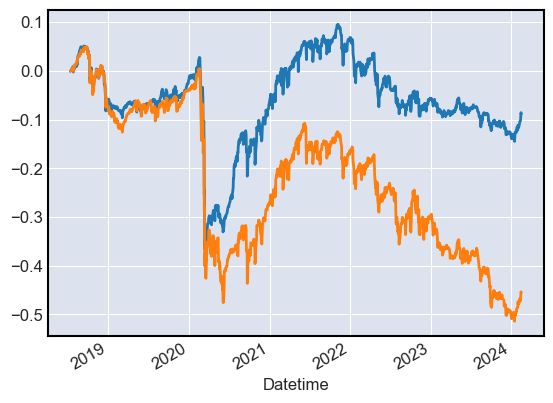

In [1096]:
pd.concat(meta_pnls.values(),axis=1).mean(axis=1).loc[test_index].cumsum().plot()
pd.concat(pnls.values(),axis=1).mean(axis=1).loc[test_index].cumsum().plot()

<Axes: xlabel='Datetime'>

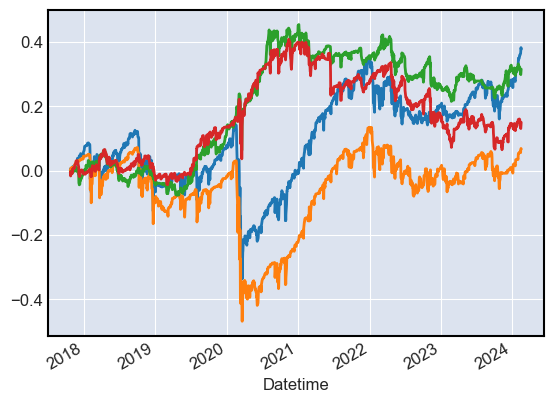

In [1072]:
meta_pnls['SPY'].loc[test_index[:round(len(test_index)/2)]].mean(axis=1).cumsum().plot()
pnls['SPY'].loc[test_index[:round(len(test_index)/2)]].mean(axis=1).cumsum().plot()

meta_pnls['GLD'].loc[test_index[:round(len(test_index)/2)]].mean(axis=1).cumsum().plot()
pnls['GLD'].loc[test_index[:round(len(test_index)/2)]].mean(axis=1).cumsum().plot()

In [982]:
pnl

,EWMAC_16,EWMAC_32,EWMAC_48,EWMAC_64,MR_5,MR_10,MR_15,MR_20
Datetime,,,,,,,,
1993-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-02-12,-0.027738,-0.027738,-0.027738,-0.027738,0.014685,0.021787,0.027738,0.027738
2024-02-13,0.018093,0.018093,0.018093,0.018093,0.018093,0.001040,-0.003863,-0.012030
2024-02-14,0.013752,0.013752,0.013752,0.013752,0.000097,-0.003466,-0.008701,-0.013752


In [434]:
sr_df

,vanilla,meta
MR_2,-23.423118,NaN
MR_4,-19.917077,0.579590
MR_8,-15.541017,0.558693


In [363]:
df.loc[train_index]

,0,RSI_8,STO_8,VOL_8,ATR_8,MACD_8,ADX_8,RSI_16,STO_16,VOL_16,...,ADX_64,VIX,EVZ,USD,MKT,SMB,HML,RMW,CMA,RF
Datetime,,,,,,,,,,,,,,,,,,,,,
2008-08-01 00:00:00,2.0,34.334870,-14.705882,0.000467,0.001636,0.000184,23.306468,40.932854,-6.097561,0.000881,...,14.292109,22.57,8.93,0.002531,-0.47,0.77,0.93,-0.39,-0.45,0.006
2008-08-01 01:00:00,2.0,36.464138,-53.571429,0.000491,0.001769,0.000121,24.001669,41.717729,-37.500000,0.000782,...,14.224738,22.57,8.93,0.002531,-0.47,0.77,0.93,-0.39,-0.45,0.006
2008-08-01 02:00:00,2.0,36.464138,-23.809524,0.000496,0.001748,0.000065,24.609971,41.717729,-12.500000,0.000439,...,14.158419,22.57,8.93,0.002531,-0.47,0.77,0.93,-0.39,-0.45,0.006
2008-08-01 03:00:00,3.0,45.668454,-40.000000,0.000544,0.001754,-0.000026,24.178802,45.041323,-10.000000,0.000436,...,14.084406,22.57,8.93,0.002531,-0.47,0.77,0.93,-0.39,-0.45,0.006
2008-08-01 04:00:00,-3.0,39.181439,-70.000000,0.000389,0.001760,-0.000039,24.432046,42.458667,-17.500000,0.000449,...,14.018817,22.57,8.93,0.002531,-0.47,0.77,0.93,-0.39,-0.45,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-25 06:00:00,3.0,61.454363,44.696970,0.000402,0.000915,-0.000078,25.479943,52.626240,33.333333,0.000479,...,15.401001,14.74,8.98,0.000927,0.00,0.45,-0.07,0.06,0.06,0.001
2016-03-25 07:00:00,-3.0,51.158889,46.212121,0.000472,0.000893,-0.000063,22.851616,48.479031,34.463277,0.000496,...,15.432736,14.74,8.98,0.000927,0.00,0.45,-0.07,0.06,0.06,0.001
2016-03-25 08:00:00,-2.0,45.626247,-108.955224,0.000495,0.000895,-0.000030,22.428941,46.028601,-4.519774,0.000499,...,15.489224,14.74,8.98,0.000927,0.00,0.45,-0.07,0.06,0.06,0.001


In [362]:
meta_pred

,EWMAC_32,EWMAC_64,EWMAC_128,MR_2,MR_4,MR_8
0,2.0,-2.0,2.0,2.0,2.0,2.0
1,3.0,2.0,2.0,3.0,2.0,3.0
2,2.0,2.0,2.0,2.0,2.0,2.0
3,-2.0,-2.0,2.0,2.0,2.0,2.0
4,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...
47529,-2.0,2.0,2.0,3.0,-3.0,-2.0
47530,-2.0,2.0,2.0,-3.0,-3.0,-2.0
47531,-2.0,2.0,2.0,3.0,3.0,2.0
47532,-2.0,2.0,2.0,3.0,3.0,2.0


In [ ]:
from sklearn.ensemble import RandomForestClassifier

for symbol in symbols:
  pnl = pnls[symbol]
  vol = np.log(data[symbol].Close).diff().rolling(240).std()
  pnl_label = pnl / vol
  

df = pd.concat([tf.pnl_vol.apply(label),
                features_df],
               axis=1).loc[data.index].ffill().dropna()
rf = RandomForestClassifier(n_estimators=500,max_depth=5)

train_index = df.index[:round(df.shape[0]*0.5)]
test_index = df.index[round(df.shape[0]*0.5)+252:]

rf.fit(y=df.iloc[:,0].loc[train_index],
       X=df.iloc[:,1:].loc[train_index])
valid = pd.DataFrame()
valid['true'] = df.iloc[:,0].loc[test_index]
valid['pred'] = rf.predict(X=df.iloc[:,1:].loc[test_index])
valid['tp'] = np.where(valid.true == valid.pred,1,0)
print(valid['tp'].mean())

meta_tf = pd.DataFrame()
meta_tf['signal'] = tf.signal
meta_tf['pred'] = valid['pred'].rolling(2).mean().clip(lower=0)
meta_tf['meta_signal'] = meta_tf.signal * meta_tf.pred
meta_tf['pnl'] = meta_tf.meta_signal * tf.logprc.diff().shift(-1)